# **IMPLEMENTATION OF GAN**

**CHECKING FOR GPU AVAILABLE FOR TRANING**

In [ ]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

In [ ]:
BATCH_SIZE = 256
NOISE_DIM = 50

IMG_SIZE  = 128

**DATA PREPROCESSING (DATA AUGMENATION)**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from skimage import io

datagen = ImageDataGenerator(        
            rotation_range=45,
            width_shift_range=0.3,  
            height_shift_range=0.3,    
            shear_range=0.25,        
            zoom_range=0.25,        
            horizontal_flip=True,         
            fill_mode='reflect')


In [ ]:
image_directory = '/kaggle/input/cat-dataset/CAT_00/' # Applying Data augmentation on CAT_00 folder
SIZE = 128
dataset = []

my_images = os.listdir(image_directory)
for i, image_name in enumerate(my_images):   
    if (image_name.split('.')[-1] == 'jpg'): 
        image = io.imread(image_directory + image_name)     
        image = Image.fromarray(image, 'RGB')        
        image = image.resize((SIZE,SIZE)) 
        dataset.append(np.array(image))

In [ ]:
!mkdir /kaggle/working/cat-augmented  # Creating car-augmented directoy to store augmented image

In [ ]:
x = np.array(dataset)
i = 0
for batch in datagen.flow(x, batch_size=20,
                          save_to_dir='/kaggle/working/cat-augmented/', # Saving the augmented images into the car-augmenated directory
                          save_prefix='aug',
                          save_format='jpg'):
    i+=1
    if i > 19: #Epochs
        break

**EXTRACTING IMAGE FROM DATASET**

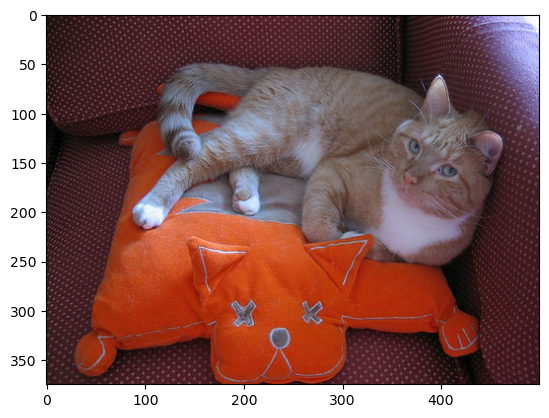

In [ ]:
list_ds = tf.data.Dataset.list_files(f'/kaggle/input/cat-dataset/CAT_00/*.jpg')
for i in range(1,5):
    list_ds = list_ds.concatenate(tf.data.Dataset.list_files(f'/kaggle/input/cat-dataset/CAT_0{i}/*.jpg')) # Extracting immages from all folders of dataset

list_ds = list_ds.concatenate(tf.data.Dataset.list_files('/kaggle/working/cat-augmented/*.jpg'))
cat_ds = list_ds.map(lambda x: tf.image.decode_jpeg(tf.io.read_file(x)))

for i in cat_ds:
    plt.imshow(i)
    break

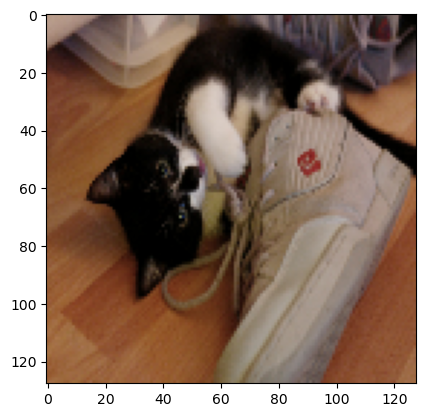

In [ ]:
# RESIZING THE IMAGE TO 128*128
def configure_for_performance(ds):
    IMG_SIZE = 128
    ds = ds.map(lambda x: tf.image.resize(x, (IMG_SIZE, IMG_SIZE))/255)
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = cat_ds
train_ds = configure_for_performance(train_ds)

for i in train_ds:
    plt.imshow(i[0])
    break

## CREATION OF MODEL

**GENERATOR MODEL**

In [ ]:
FILTER_COUNT = 16
IN_LAYER_COUNT = 6


def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(
        (IMG_SIZE//(2**IN_LAYER_COUNT))*(IMG_SIZE//(2**IN_LAYER_COUNT))*NOISE_DIM, use_bias=False, input_shape=(NOISE_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((IMG_SIZE//(2**IN_LAYER_COUNT),
              IMG_SIZE//(2**IN_LAYER_COUNT), NOISE_DIM)))

    for i in range(IN_LAYER_COUNT):
        model.add(layers.Conv2DTranspose(FILTER_COUNT*2**(IN_LAYER_COUNT-i-1),
                  (6, 6), strides=(2, 2), padding='same', use_bias=False))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (6, 6), strides=(1, 1),
                                     padding='same', use_bias=False, activation='sigmoid'))
    assert model.output_shape == (None, IMG_SIZE, IMG_SIZE, 3)

    return model


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               10000     
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 200)               0         
                                                                 
 reshape (Reshape)           (None, 2, 2, 50)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 512)        921600    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 4, 4, 512)        2

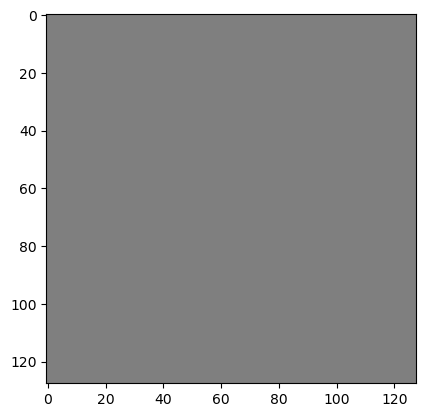

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, NOISE_DIM])
generated_image = generator(noise, training=False)
generator.summary()

plt.imshow(generated_image[0, :, :, :])

**DISCRIMINATOR MODEL**

In [ ]:
DISC_FILTER_COUNT = FILTER_COUNT
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(DISC_FILTER_COUNT, (6, 6), strides=(2, 2), padding='same',
                                     input_shape=[IMG_SIZE, IMG_SIZE, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    for i in range(1, IN_LAYER_COUNT):
        model.add(layers.Conv2D(DISC_FILTER_COUNT*(2**i), (6, 6), strides=(2, 2), padding='same'))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1,activation='sigmoid'))

    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        1744      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 64, 64, 16)        0         
                                                                 
 dropout (Dropout)           (None, 64, 64, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)       

### **LOSS FUNCTION**

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()

**Discriminator loss** 

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

**Generator loss**

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

**OPTIMIZER**

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

**SAVING CHECKPOINTS**

In [ ]:
checkpoint_dir = '/kaggle/working/models'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, NOISE_DIM])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

### **MODEL TRAINING**

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables))

    return (gen_loss, disc_loss)


def train(dataset, epochs):
    gen_losses = []
    disc_losses = []

    for epoch in range(epochs):
        start = time.time()
        gen_loss = disc_loss = batch_count = 0

        for image_batch in dataset:
            (step_gen_loss, step_disc_loss) = train_step(image_batch)
            gen_loss += step_gen_loss
            disc_loss += step_disc_loss
            batch_count += 1

        # Save each epoch loss during training
        gen_losses.append(gen_loss/batch_count)
        disc_losses.append(disc_loss/batch_count)

        display.clear_output(wait=True)
        plot_losses(gen_losses, disc_losses)

        # Produce images for the GIF as you go
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed, epoch % 25 == 0)

        # Save the model every 15 epochs
        if (epoch + 1) % 100 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print('Time for epoch {} is {} sec'.format(
            epoch + 1, time.time()-start))

**PLOTTING THE LOSS**

In [ ]:
def plot_losses(gen_losses, disc_losses):
    plt.plot(gen_losses, label='Generator')
    plt.plot(disc_losses, label='Discriminator')
    plt.legend()
    plt.show()


def generate_and_save_images(model, epoch, test_input, save=False):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :])
        plt.axis('off')
    if save:
        plt.savefig('/kaggle/working/generated/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


In [ ]:
!mkdir /kaggle/working/generated  # Creating generated directory to store the fake images

### **BELOW COMMAND IS TO TRAIN THE MODEL**

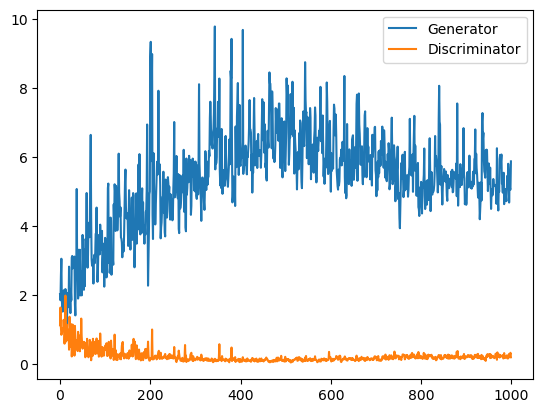

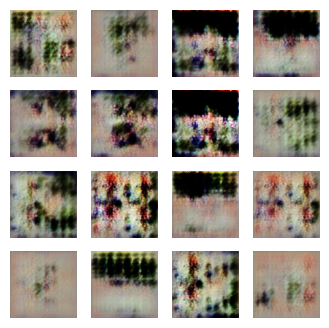

Time for epoch 1000 is 11.695569038391113 sec


In [ ]:
train(train_ds, 5500)

### **CREATING A GIF**


tf.Tensor([[0.00024981]], shape=(1, 1), dtype=float32)


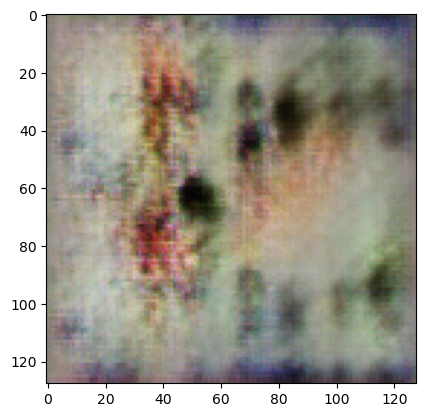

In [ ]:
noise = tf.random.normal([1, NOISE_DIM])
generated_image = generator(noise, training=False)
decision = discriminator(generated_image, training=False)

print(decision)
plt.imshow(generated_image[0, :, :, :])
plt.savefig('generated/image_test.png')


In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('generated/image_at_epoch_{:04d}.png'.format(epoch_no))

Using `imageio` we create an animated gif using the images saved during training.

In [ ]:
anim_file = '/kaggle/working/generated/cats_gan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('generated/image_at*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  if __name__ == "__main__":



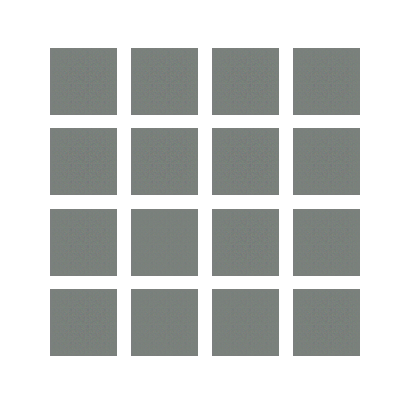

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

## **MODEL EVALUATION**

**FID SCORE**

In [ ]:
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
import cv2
 
# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)
 
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
 # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
 # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
 # calculate sum squared difference between means
    ssdiff = numpy.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
# check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
 # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid
 
    
img = None
for i in train_ds:
    img = np.array(i[0]) # Storing one image from the dataset 
    break
# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
# define two fake collections of images
fake = np.array(generator(noise, training=False)[0, :, :, :])
fake = fake.reshape((16,32,32,3))
real = img
real = real.reshape((16,32,32,3))
# convert integer to floating point values
images1 = images1.astype('float32')
images2 = images2.astype('float32')
# resize images
images1 = scale_images(images1, (299,299,3))
images2 = scale_images(images2, (299,299,3))
print('Scaled', images1.shape, images2.shape)
# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)
# fid between images1 and images2
fid = calculate_fid(model, images1, images2)
print('FID (different): %.3f' % fid)